<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis/blob/main/alldata/Replicate_GCP1_main_conclusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GCP_data/all_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GCP_data/all_data


In [7]:
#download the formal event registry and read the events in
!wget https://global-mind.org/pred_formal.html -O pred_formal.html

--2023-12-19 13:12:19--  https://global-mind.org/pred_formal.html
Resolving global-mind.org (global-mind.org)... 162.245.217.130
Connecting to global-mind.org (global-mind.org)|162.245.217.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘pred_formal.html’

pred_formal.html        [  <=>               ] 184.64K   389KB/s    in 0.5s    

2023-12-19 13:12:21 (389 KB/s) - ‘pred_formal.html’ saved [189067]



In [8]:
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import os

#parse the html
soup = BeautifulSoup(open("/content/drive/MyDrive/GCP_data/pred_formal.html").read())

#the 'recipe' and 'statistic' columns don't always get parsed correctly due
# to the break, but we can work around it
rows = [[td.contents[0].rstrip() for td in row.find_all("td") ]
        for row in soup.body.table.tbody.find_all("tr")]

#prepare the event IDs to be analyzed
included_events = []
for row in rows:
  if row[-1].startswith("Yes"): #only keep those events used in the GCP analysis (e.g. exclude events noted as redundant or post-hoc)
    event_num = row[0]
    event_name = row[1]
    start, end = row[2], row[3]
    start_datetime = datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
    end_datetime = datetime.strptime(end, '%Y-%m-%d %H:%M:%S')
    duration = 1 + (end_datetime - start_datetime).total_seconds()
    if (end_datetime < start_datetime):
      print("Skipping because end < start:", event_num, event_name, start, end)
      continue
    if (duration > 7*24*60*60):
      print("Skipping because event is more than 7 days long!", event_num, event_name, start, end)
      continue
    if ("New Year Var" in event_name):
      print("Skipping because redundant with a corresponding 'mean' event: ", event_num, event_name, start, end)
      continue

    included_events.append((event_num, event_name, start_datetime, end_datetime, duration))

Skipping because event is more than 7 days long! 25 Pray for Peace 1999-04-03 20:00:00 1999-05-03 19:01:59
Skipping because redundant with a corresponding 'mean' event:  43 New Year Var 99-00 1999-12-31 09:30:00 2000-01-01 11:29:59
Skipping because event is more than 7 days long! 51 Kursk, 10 days 2000-08-12 07:28:00 2000-08-21 14:29:59
Skipping because redundant with a corresponding 'mean' event:  65 New Year Var 00-01 2000-12-31 09:30:00 2001-01-01 11:29:59
Skipping because event is more than 7 days long! 79 Buddhist Stupa Ceremony 2001-08-09 06:30:00 2001-08-17 14:59:59
Skipping because redundant with a corresponding 'mean' event:  98 New Year Var 01-02 2001-12-31 09:30:00 2002-01-01 11:29:59
Skipping because redundant with a corresponding 'mean' event:  126 New Year Variance 2002-12-31 09:30:00 2003-01-01 11:29:59
Skipping because redundant with a corresponding 'mean' event:  163 New Year Variance 2003-12-31 09:30:00 2004-01-01 11:29:59
Skipping because redundant with a correspondi

In [9]:
len(included_events)

479

In [10]:
#download the list of 'bad data'
!wget https://global-mind.org/rotteneggs -O rotteneggs.txt

--2023-12-19 13:12:31--  https://global-mind.org/rotteneggs
Resolving global-mind.org (global-mind.org)... 162.245.217.130
Connecting to global-mind.org (global-mind.org)|162.245.217.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4192 (4.1K)
Saving to: ‘rotteneggs.txt’

rotteneggs.txt      100%[===================>]   4.09K  --.-KB/s    in 0s      

2023-12-19 13:12:32 (131 MB/s) - ‘rotteneggs.txt’ saved [4192/4192]



In [11]:
from collections import defaultdict
import numpy as np
import h5py
import traceback
import scipy

class GCPMissingDataError(RuntimeError):
  pass

#Instantiate a GCP data reader to read data from the hdf5 files
class GCPDataReader(object):

  def __init__(self, bad_data_file="rotteneggs.txt", year_to_hdf5path=lambda x: "GCP1data_"+str(x)+".hdf5"):
    #reorganize the bad data list by device ID
    self.bad_data_lookup = defaultdict(list)
    for baddata_starttime, baddata_endtime, deviceid in self.parse_bad_data_file(bad_data_file):
      self.bad_data_lookup[deviceid].append((baddata_starttime, baddata_endtime))
    self.year_to_hdf5fh = {} #mapping from the year to the hdf5 file handle
    self.year_to_hdf5path = year_to_hdf5path

  def parse_bad_data_file(self, file):
    bad_data_list = []
    #read in the bad data durations
    for line in open(file, 'r'):
      line = line.rstrip("\n")
      if line.startswith("47")==False: #ignore lines not starting with 47
        continue
      else:
        _,start,end,deviceid = line.split(",")
        #there appear to be some cases of manual errors that need to be corrected
        if (end=="2001-06-31 23:59:59"):
          print("manually correcting",line)
          end="2001-06-30 23:59:59"
        if (end=="2008-04-55 23:59:59"):
          print("manually correcting",line)
          end="2008-04-30 23:59:59"
        #If end is 'current', set to datetime.now()
        if (end.startswith("current--*")):
          end=datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        start_datetime = datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
        end_datetime = datetime.strptime(end, '%Y-%m-%d %H:%M:%S')
        bad_data_list.append((start_datetime, end_datetime, int(deviceid) ))
    return bad_data_list

  def fetch_data(self, starttime, endtime):

    if (endtime.strftime("%Y-%m-%d") == starttime.strftime("%Y-%m-%d")):
      return self.fetch_data_within_day(starttime, endtime) #returns both data and devices
    else:
      #split into accesses over multiple days
      start_day = starttime.strftime("%Y-%m-%d")
      end_day = endtime.strftime("%Y-%m-%d")
      #for the first day:
      day_accesses = [ (
          starttime,
          datetime.strptime(start_day+" 23:59:59", '%Y-%m-%d %H:%M:%S')) ]
      #for intermediate days:
      dayoffset = 1
      inter_day = (starttime + timedelta(days=dayoffset)).strftime("%Y-%m-%d")
      while inter_day != end_day:
        day_accesses.append(
            (datetime.strptime(inter_day+" 00:00:00", '%Y-%m-%d %H:%M:%S'),
             datetime.strptime(inter_day+" 23:59:59", '%Y-%m-%d %H:%M:%S')))
        dayoffset += 1
        inter_day = (starttime + timedelta(days=dayoffset)).strftime("%Y-%m-%d")

      #for the final day
      day_accesses.append(
          (datetime.strptime(inter_day+" 00:00:00", '%Y-%m-%d %H:%M:%S'),
           endtime))
      days_data_and_devices = [self.fetch_data_within_day(t1, t2) for (t1,t2) in day_accesses]
      #if all the days have the same sets of devices...
      if (len(set([str(x[1]) for x in days_data_and_devices]))==1):
        return np.concatenate([x[0] for x in days_data_and_devices], axis=0), days_data_and_devices[0][1]
      else:
        #print("Some days don't have same devices. Rearranging")
        all_devices = set()
        [all_devices.update(x[1]) for x in days_data_and_devices]
        all_devices = sorted(all_devices)
        all_devices_newidxs = dict([(x[1],x[0]) for x in enumerate(all_devices)])
        rearranged_days_data = []
        for day_data, day_devices in days_data_and_devices:
          rearranged_day_data = np.zeros((len(day_data), len(all_devices)))
          rearranged_day_data[:,:] = np.nan
          for orig_deviceidx, deviceid in enumerate(day_devices):
            rearranged_day_data[:,all_devices_newidxs[deviceid]] = day_data[:,orig_deviceidx]
          rearranged_days_data.append(rearranged_day_data)
        return np.concatenate(rearranged_days_data, axis=0), all_devices

  def fetch_data_within_day(self, starttime, endtime):
    assert endtime.strftime("%Y-%m-%d") == starttime.strftime("%Y-%m-%d")
    year = starttime.year
    if (year not in self.year_to_hdf5fh):
      self.year_to_hdf5fh[year] = h5py.File(self.year_to_hdf5path(year), "r")
    fh = self.year_to_hdf5fh[year]
    day = starttime.strftime("%Y-%m-%d")
    if (day not in fh):
      raise GCPMissingDataError("data for "+day+" not present")
    dset = fh[day]
    if dset.attrs['start_time'] > starttime.timestamp():
      raise GCPMissingDataError("query for day "
             +day+" starts at "+str(starttime.timestamp())
             +" but data for day starts at "+str(dset.attrs['start_time']))
    if dset.attrs['end_time'] < endtime.timestamp():
      raise GCPMissingDataError("query for day "
             +day+" ends at "+str(endtime.timestamp())
             +" but data for day ends at "+str(dset.attrs['end_time']))
    #now that we have verified that the day has all the data we need...
    start_offset = int(starttime.timestamp() - dset.attrs['start_time'])
    end_offset = int(endtime.timestamp()+1 - dset.attrs['start_time']) #add +1 since GCP ranges are end-inclusive
    day_data = np.array(dset[start_offset:end_offset]).astype("float")
    #replace 255 with nan
    day_data[day_data==255] = np.nan

    #Mask out columns with bad data
    masking_occurred = False
    devices_on_day = fh[day].attrs["device_ids"]
    for deviceid_idx,deviceid in enumerate(devices_on_day):
      if (deviceid in self.bad_data_lookup):
        for rottenegg_start, rottenegg_end in self.bad_data_lookup[deviceid]:
          if (rottenegg_start.timestamp() <= endtime.timestamp() and rottenegg_end.timestamp() >= starttime.timestamp()):
            if (masking_occurred == False):
              print("Before masking, fraction of nans in raw data is", np.mean(np.isnan(day_data)),"for",starttime,"to",endtime)
            masking_occurred = True
            print("Found 'rotten egg' entries for device id:",deviceid,
                  "in time range",starttime,"to",endtime,
                  "(range:",rottenegg_start,"to",rottenegg_end,")")
            mask_startidx = int(max(rottenegg_start.timestamp()-starttime.timestamp(),0))
            mask_endidx = int(min((rottenegg_end.timestamp()+1)-starttime.timestamp(), len(day_data))) #+1 because end inclusive
            day_data[mask_startidx:mask_endidx, deviceid_idx] = np.nan

    if (masking_occurred):
      print("After masking, fraction of nans in raw data is", np.mean(np.isnan(day_data)))
    #Check that there are no rows that completely lack data
    nonnan_devices_per_second = np.sum(np.isnan(day_data)==False, axis=1)
    if (np.min(nonnan_devices_per_second)==0):
      raise GCPMissingDataError("Some seconds for query from "+str(starttime)+" to "+str(endtime)+" had no data")

    return day_data, devices_on_day

    def __exit__(self, exc_type, exc_value, traceback):
      self.close()

    def close(self):
      for fh in self.year_to_hdf5fh.values():
        fh.close()


def compare_different_calc_approaches(egg_values, blocksizes):
  #Radin 2023 (Anomalous entropic effects in physical systems associated
  # with collective consciousness) said "All individual samples within a matrix
  # less than 55 or greater than 145 were set to nan" so we do that here
  egg_values = np.where((egg_values < 55), np.nan, egg_values)
  egg_values = np.where((egg_values > 145), np.nan, egg_values)

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row

  egg_zscores = (egg_values - 100)/np.sqrt(50)

  pvaltozs_sumthensquare = []
  pvaltozs_squarethensum = []
  for blocksize in blocksizes:
    num_blocks = int((len(egg_zscores) - (len(egg_zscores)%blocksize))/blocksize)
    num_eggs = egg_zscores.shape[-1]
    blockreshaped_eggzscores = egg_zscores[0 : blocksize*num_blocks].reshape(num_blocks, blocksize, num_eggs)

    perblock_peregg_zsums = np.sum(blockreshaped_eggzscores, axis=1)/np.sqrt(blocksize) #shape becomes (num_blocks x num_eggs), nan if any value in the block is nan
    num_nonnan_eggblocks = np.sum(np.isnan(perblock_peregg_zsums)==False, axis=-1) #shape is num_blocks

    #compute p value if we sum across eggs first, then square
    perblock_zsums = np.nansum(perblock_peregg_zsums, axis=1)/np.maximum(np.sqrt(num_nonnan_eggblocks), 1) #shape becomes num_blocks
    if np.sum(np.isnan(perblock_zsums)) > 0:
      assert False, np.sum(np.isnan(perblock_zsums))
    pvaltoz_sumthensquare = scipy.stats.norm.ppf(scipy.stats.chi2.cdf(x=np.nansum(np.square(perblock_zsums)), df=np.sum(num_nonnan_eggblocks > 0)))
    pvaltozs_sumthensquare.append(pvaltoz_sumthensquare)

    #compute p value if we square first, then sum across eggs and timesteps
    pvaltoz_squarethensum = scipy.stats.norm.ppf(scipy.stats.chi2.cdf(np.nansum(np.square(perblock_peregg_zsums)),
                                                  df=np.sum(num_nonnan_eggblocks)))
    #the above code sometimes returns cdfs of 1.0, so we will also use the normal approx and take the less significant of the two
    pvaltoz_squarethensum = min(pvaltoz_squarethensum,
                                np.nansum(np.square(perblock_peregg_zsums)-1)/np.sqrt(2*np.sum(num_nonnan_eggblocks)) )
    pvaltozs_squarethensum.append(pvaltoz_squarethensum)

  return pvaltozs_sumthensquare, pvaltozs_squarethensum


BLOCKSIZES = [1, 2, 3, 6, 8, 10, 15]
all_pvaltozs_sumthensquare = []
all_pvaltozs_squarethensum = []

control_all_pvaltozs_sumthensquare = []
control_all_pvaltozs_squarethensum = []

surviving_events = [] #in case we encounter missing data errors
#read the data for the events
gcp_data_reader = GCPDataReader()

eventcount = 0

for (event_num, event_name, start_datetime, end_datetime, duration) in included_events[:]:
  eventcount += 1
  print("EVENT COUNT", eventcount)
  print(event_num, event_name, start_datetime, end_datetime, duration)
  try:
    event_data = gcp_data_reader.fetch_data(start_datetime, end_datetime)[0]
    pvaltozs_sumthensquare, pvaltozs_squarethensum = compare_different_calc_approaches(event_data, BLOCKSIZES)
    print("Event data: Sum then square:", pvaltozs_sumthensquare)
    print("Event data: Square then sum:", pvaltozs_squarethensum)
    all_pvaltozs_sumthensquare.append(pvaltozs_sumthensquare)
    all_pvaltozs_squarethensum.append(pvaltozs_squarethensum)

    print("For control...")

    control_data = gcp_data_reader.fetch_data(end_datetime+timedelta(seconds=1), end_datetime+timedelta(seconds=duration+1))[0]
    pvaltozs_sumthensquare, pvaltozs_squarethensum = compare_different_calc_approaches(control_data, BLOCKSIZES)
    print("Control data: Sum then square:", pvaltozs_sumthensquare)
    print("Control data: Square then sum:", pvaltozs_squarethensum)
    control_all_pvaltozs_sumthensquare.append(pvaltozs_sumthensquare)
    control_all_pvaltozs_squarethensum.append(pvaltozs_squarethensum)

    surviving_events.append((event_num, event_name, start_datetime, end_datetime, duration))
  except GCPMissingDataError as e:
    print("MISSING DATA ERROR!",e)

manually correcting 47,2000-01-01 00:00:00,2001-06-31 23:59:59,2222
manually correcting 47,2008-04-25 00:00:00,2008-04-55 23:59:59,1092
EVENT COUNT 1
1 Embassy 1998-08-07 07:15:00 1998-08-07 10:14:59 10800.0
Event data: Sum then square: [1.6796770942503958, 0.4790607678511112, 0.6790005001783374, 1.1302914740164636, 1.0815668627125234, 0.6812334745387302, 0.7977339541574902]
Event data: Square then sum: [1.3636899801142541, 0.44543915364945763, 0.5239696919399586, 0.4888688891554672, 0.05861589907348796, -0.17632059010521736, 1.1338059759676669]
For control...
Control data: Sum then square: [-0.023726120860630823, -0.2417890007895038, 0.3622505245024076, -0.4688654604721959, 0.1545948108562088, -1.6380480176673564, -0.7072044670203296]
Control data: Square then sum: [-0.002438866629420003, -1.316738322923869, 0.5216134563809692, -0.23670504211263016, 1.2409651018517007, -1.0904409656893275, -0.20879202663476093]
EVENT COUNT 2
3 Bomb Afghanistan 1998-08-20 17:15:00 1998-08-20 17:44:59 1

<ipython-input-11-27ee77c48163>:182: RuntimeWarning: invalid value encountered in double_scalars
  np.nansum(np.square(perblock_peregg_zsums)-1)/np.sqrt(2*np.sum(num_nonnan_eggblocks)) )


Event data: Sum then square: [1.5218989748214433, 1.232160950024768, 1.5229017323758685, 0.877112078958482, 1.8560540825716954, 1.6528609418520928, 1.5117464012823447]
Event data: Square then sum: [-0.6514236588662656, -0.5775553001817709, -0.11717181159367089, 0.37898709292026034, -0.09962438044355419, 0.7236741163996196, 0.7390240727082366]
For control...
Control data: Sum then square: [-0.4882572885546131, 0.1023249671901099, 0.1510312962493993, 0.15350133394172827, 0.20265020788438837, 0.15952777905578827, -1.601251007351741]
Control data: Square then sum: [-1.4173519590019474, -0.8770015314479557, -1.1302981671259134, -0.18808188391506103, 0.14322263338822824, 0.2348263417047412, -0.4449705752629649]
EVENT COUNT 67
84 MUM Peace Meditation 2001-09-23 11:45:00 2001-09-27 23:29:59 387900.0
Event data: Sum then square: [0.2544874594428339, -0.4536605352288798, 1.7415690989918358, 0.8379622194818437, 1.1018519098740183, 1.7844819307100837, 0.7211240023101421]
Event data: Square then su

num events: 479



************TEST TYPE: actual
Blocksize: 1 seconds
Meta-analysis Z-score if squaring *after* summing: 6.4154099629922925
Meta-analysis Z-score if squaring *before* summing 6.387308532164188
Argmax event for square after summing: ('487', 'September 21', datetime.datetime(2014, 9, 21, 0, 0), datetime.datetime(2014, 9, 21, 23, 59, 59), 86400.0) 3.220190532336857
Argmax event for square before summing: ('271', 'Obama Acceptance 080828', datetime.datetime(2008, 8, 29, 2, 0), datetime.datetime(2008, 8, 29, 3, 59, 59), 7200.0) 3.693110187603022
Correlation between the two scores: PearsonRResult(statistic=0.08458282047922579, pvalue=0.0652075325375841)


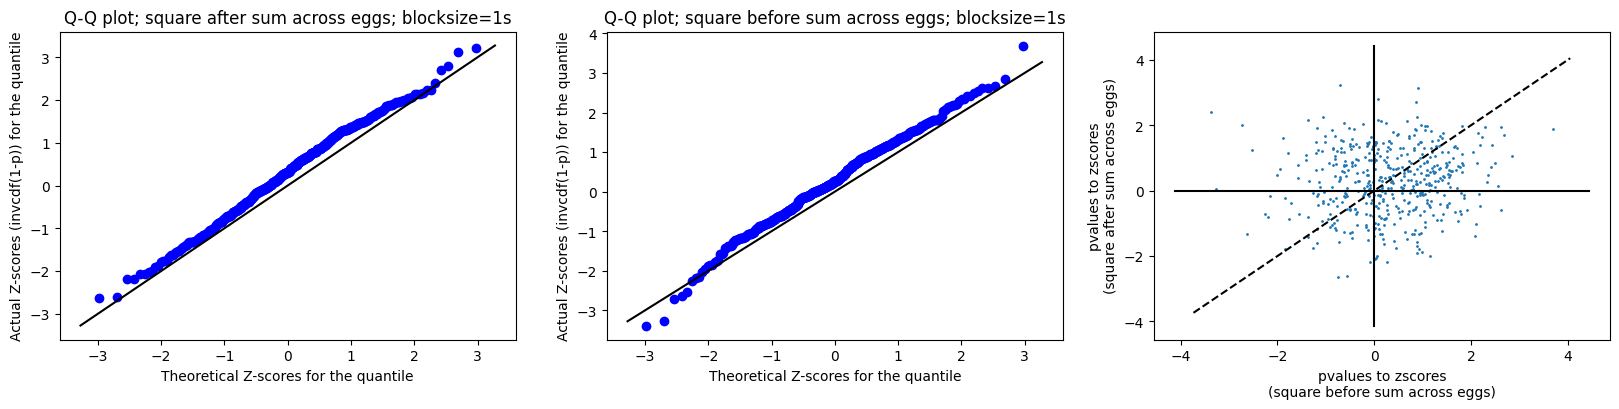

Blocksize: 2 seconds
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 3.505549651798697
Meta-analysis Z-score if squaring *before* summing 4.983656392242275
Argmax event for square after summing: ('216', 'Earth Day, 2006', datetime.datetime(2006, 4, 22, 0, 0), datetime.datetime(2006, 4, 22, 23, 59, 59), 86400.0) 2.8536347510654143
Argmax event for square before summing: ('270', 'World Meditation 080816', datetime.datetime(2008, 8, 16, 10, 0), datetime.datetime(2008, 8, 16, 10, 59, 59), 3600.0) 2.8839907600209322
Correlation between the two scores: PearsonRResult(statistic=0.1656597295023606, pvalue=0.00028779928219583385)


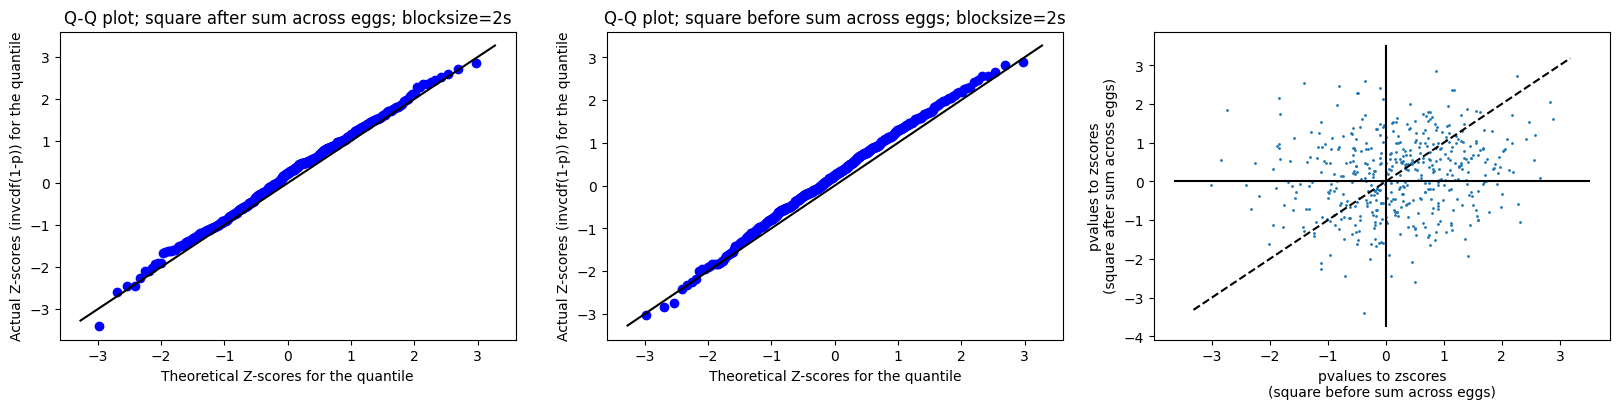

Blocksize: 3 seconds
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 2.830149582405965
Meta-analysis Z-score if squaring *before* summing 5.265538403342386
Argmax event for square after summing: ('208', 'India Bombs', datetime.datetime(2005, 10, 29, 11, 8), datetime.datetime(2005, 10, 29, 16, 7, 59), 18000.0) 2.891194279937418
Argmax event for square before summing: ('256', 'New Year Mean, 2008', datetime.datetime(2007, 12, 31, 9, 30), datetime.datetime(2008, 1, 1, 12, 29, 59), 97200.0) 3.0604074389762403
Correlation between the two scores: PearsonRResult(statistic=0.17999807109524274, pvalue=7.983433553602252e-05)


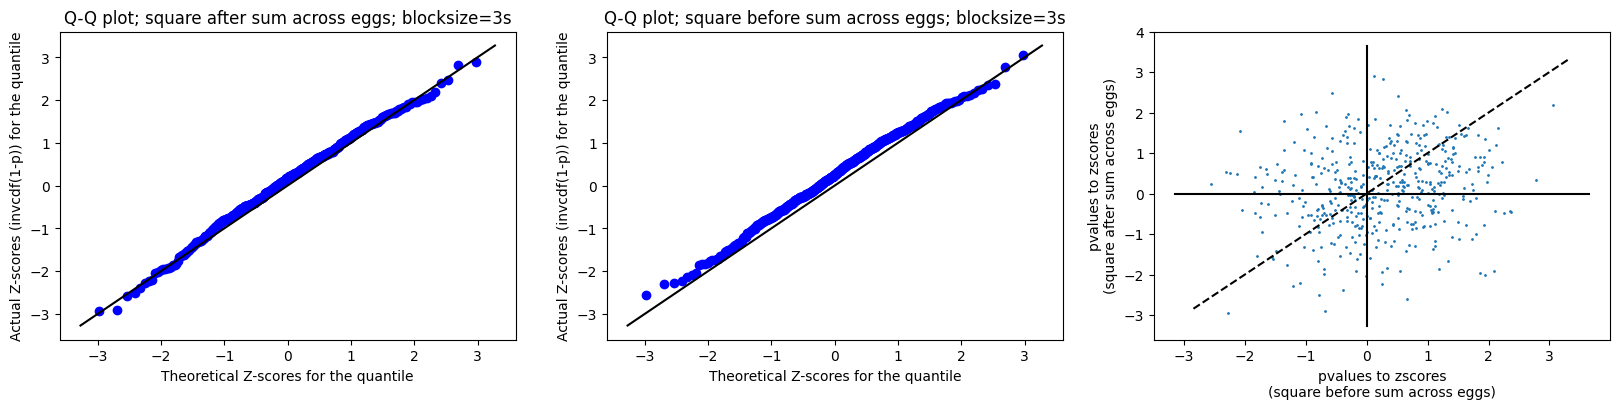

Blocksize: 6 seconds
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 2.5151332144580767
Meta-analysis Z-score if squaring *before* summing 2.910461136577346
Argmax event for square after summing: ('320', 'Haiti Earthquake', datetime.datetime(2010, 1, 12, 20, 0), datetime.datetime(2010, 1, 13, 3, 59, 59), 28800.0) 2.8309505261170873
Argmax event for square before summing: ('73', 'Earth Day, 2001', datetime.datetime(2001, 4, 22, 0, 0), datetime.datetime(2001, 4, 22, 23, 59, 59), 86400.0) 4.0092378700332825
Correlation between the two scores: PearsonRResult(statistic=0.1816722229341031, pvalue=6.827801314436883e-05)


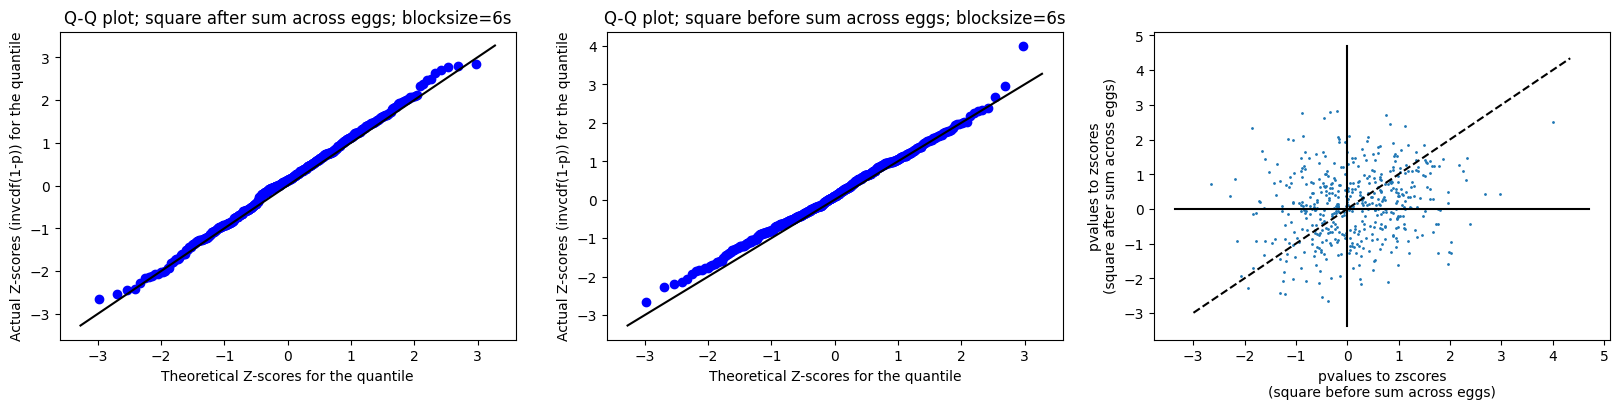

Blocksize: 8 seconds
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 1.9317811756630179
Meta-analysis Z-score if squaring *before* summing 1.7382003066385217
Argmax event for square after summing: ('173', 'Korean Train Explosion', datetime.datetime(2004, 4, 22, 3, 0), datetime.datetime(2004, 4, 22, 6, 59, 59), 14400.0) 2.868766153620809
Argmax event for square before summing: ('256', 'New Year Mean, 2008', datetime.datetime(2007, 12, 31, 9, 30), datetime.datetime(2008, 1, 1, 12, 29, 59), 97200.0) 3.9322841444815113
Correlation between the two scores: PearsonRResult(statistic=0.17210277433444388, pvalue=0.00016379107957017913)


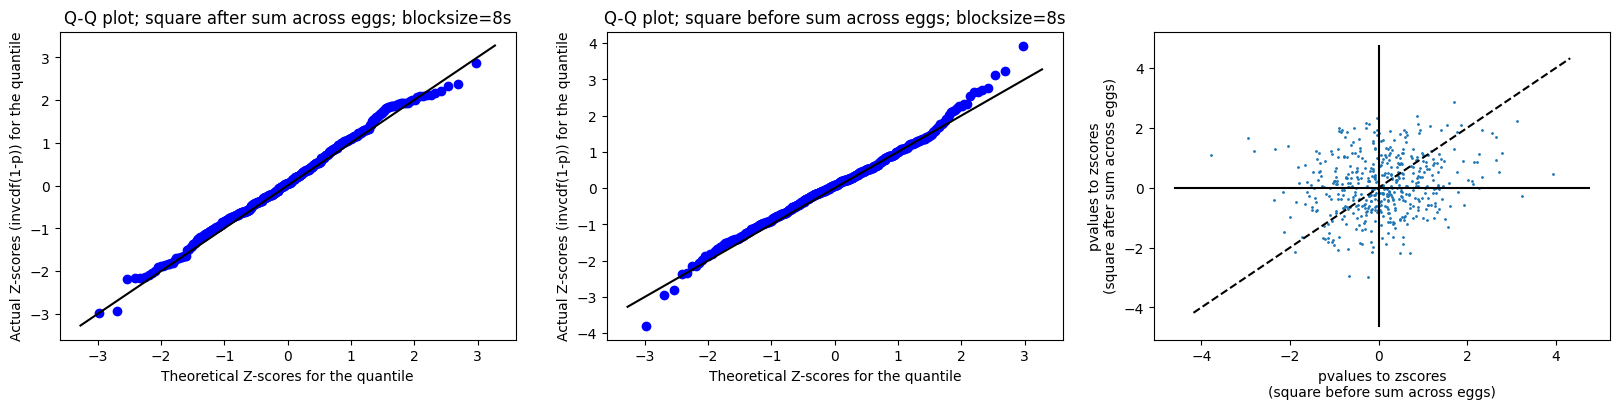

Blocksize: 10 seconds
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 1.2960599816600473
Meta-analysis Z-score if squaring *before* summing 2.109919218220639
Argmax event for square after summing: ('89', 'World Series, Yankee Stadium', datetime.datetime(2001, 11, 1, 0, 0), datetime.datetime(2001, 11, 1, 4, 59, 59), 18000.0) 3.29727774692361
Argmax event for square before summing: ('256', 'New Year Mean, 2008', datetime.datetime(2007, 12, 31, 9, 30), datetime.datetime(2008, 1, 1, 12, 29, 59), 97200.0) 3.2858793279659446
Correlation between the two scores: PearsonRResult(statistic=0.10763321986535544, pvalue=0.018953151580741682)


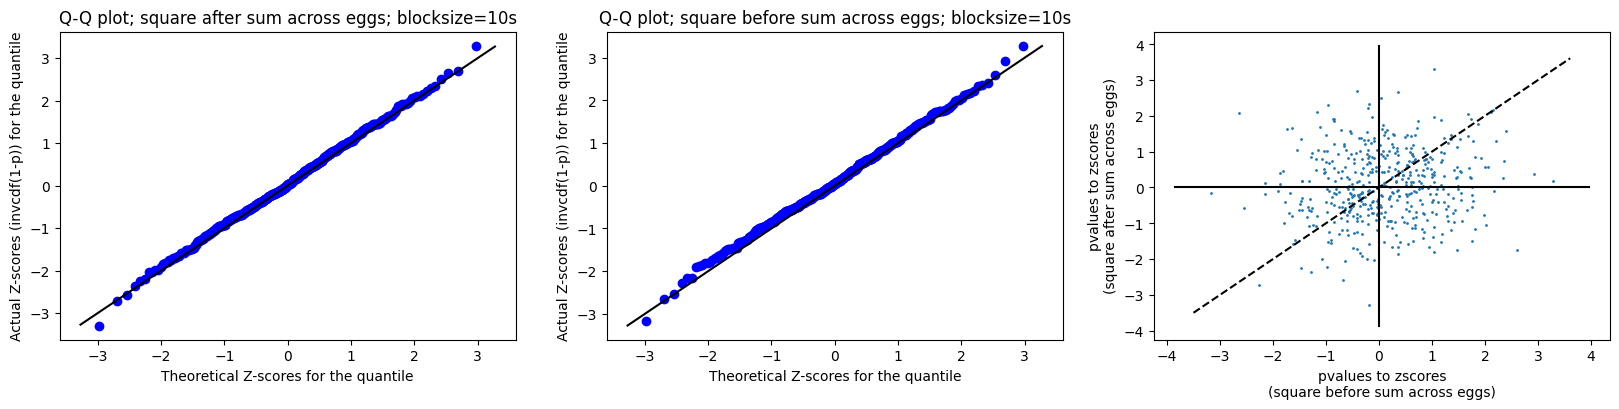

Blocksize: 15 seconds
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 0.34714408993118273
Meta-analysis Z-score if squaring *before* summing 1.9956308619513015
Argmax event for square after summing: ('89', 'World Series, Yankee Stadium', datetime.datetime(2001, 11, 1, 0, 0), datetime.datetime(2001, 11, 1, 4, 59, 59), 18000.0) 2.841416405131285
Argmax event for square before summing: ('137', 'Begin War on Iraq -4 +4 hours', datetime.datetime(2003, 3, 19, 23, 15), datetime.datetime(2003, 3, 20, 7, 14, 59), 28800.0) 3.0185948021375433
Correlation between the two scores: PearsonRResult(statistic=0.18412411979315957, pvalue=5.416581482402723e-05)


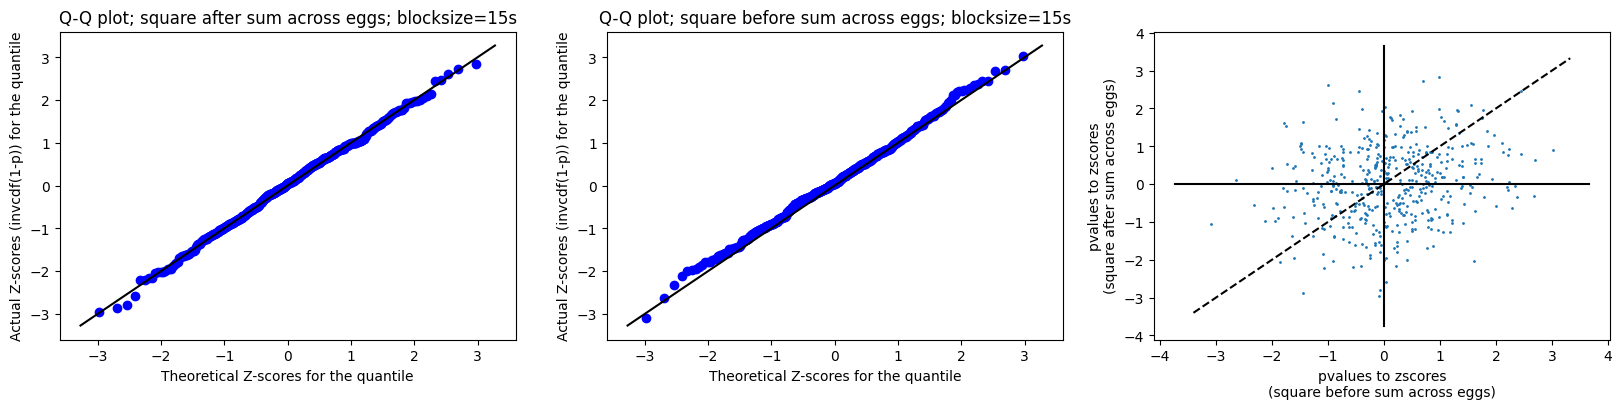




************TEST TYPE: control
Blocksize: 1 seconds
Meta-analysis Z-score if squaring *after* summing: -2.37462728344626
Meta-analysis Z-score if squaring *before* summing 2.7602822881143045
Argmax event for square after summing: ('453', 'Night of Hopes', datetime.datetime(2013, 5, 16, 15, 30), datetime.datetime(2013, 5, 16, 16, 59, 59), 5400.0) 3.2325190055261315
Argmax event for square before summing: ('214', 'Golden Dome Bomb', datetime.datetime(2006, 2, 22, 3, 0), datetime.datetime(2006, 2, 22, 6, 59, 59), 14400.0) 2.9116008341430826
Correlation between the two scores: PearsonRResult(statistic=0.18235025225128235, pvalue=6.292848000158205e-05)


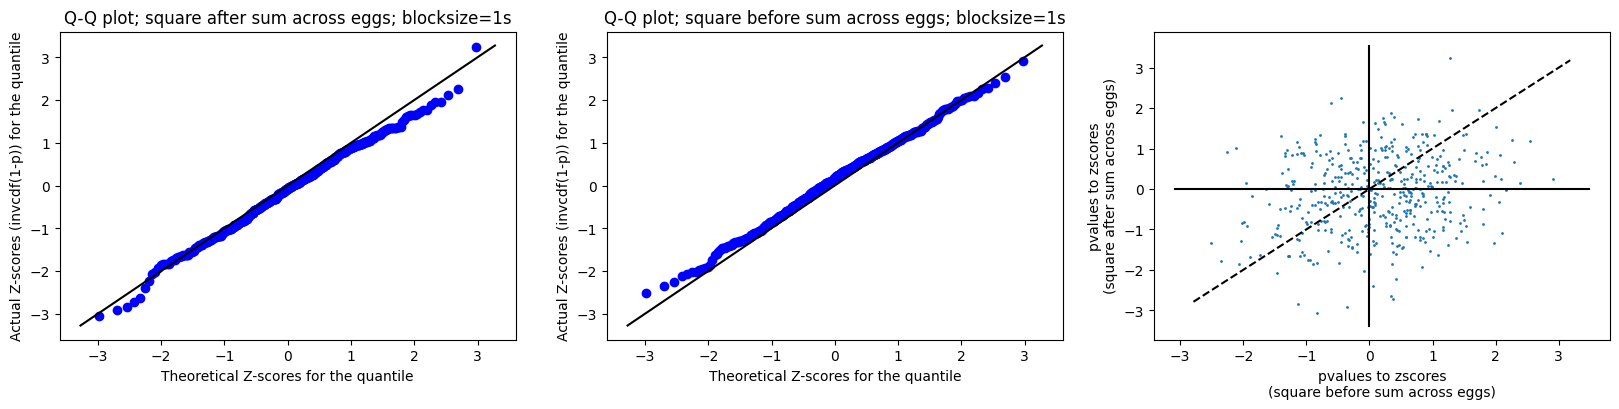

Blocksize: 2 seconds
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -1.6137966580679084
Meta-analysis Z-score if squaring *before* summing 1.7773978270918391
Argmax event for square after summing: ('453', 'Night of Hopes', datetime.datetime(2013, 5, 16, 15, 30), datetime.datetime(2013, 5, 16, 16, 59, 59), 5400.0) 2.741751042891698
Argmax event for square before summing: ('414', 'Avalanch Pakistan', datetime.datetime(2012, 4, 7, 4, 0), datetime.datetime(2012, 4, 7, 9, 59, 59), 21600.0) 2.8341108661417036
Correlation between the two scores: PearsonRResult(statistic=0.11329178244704487, pvalue=0.013390792613111706)


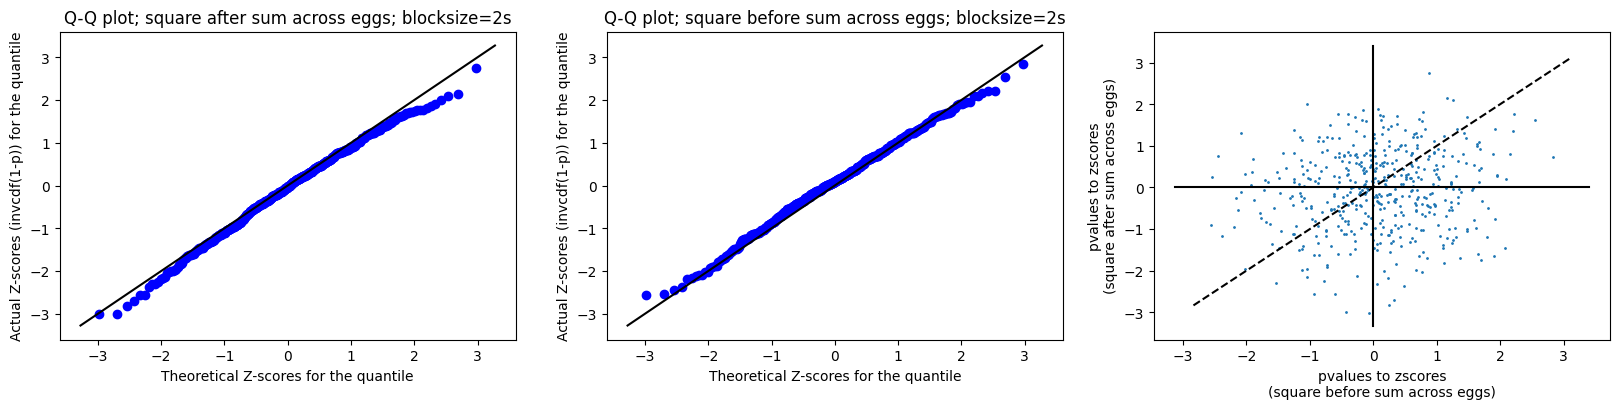

Blocksize: 3 seconds
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -0.6907238877614684
Meta-analysis Z-score if squaring *before* summing 1.6542855424384226
Argmax event for square after summing: ('268', 'Olympic Opening Beijing', datetime.datetime(2008, 8, 8, 12, 0), datetime.datetime(2008, 8, 8, 15, 59, 59), 14400.0) 3.236071823523615
Argmax event for square before summing: ('374', 'Earth Day, 2011', datetime.datetime(2011, 4, 22, 0, 0), datetime.datetime(2011, 4, 22, 23, 59, 59), 86400.0) 3.3003392700772727
Correlation between the two scores: PearsonRResult(statistic=0.17323708185897482, pvalue=0.00014800473847033995)


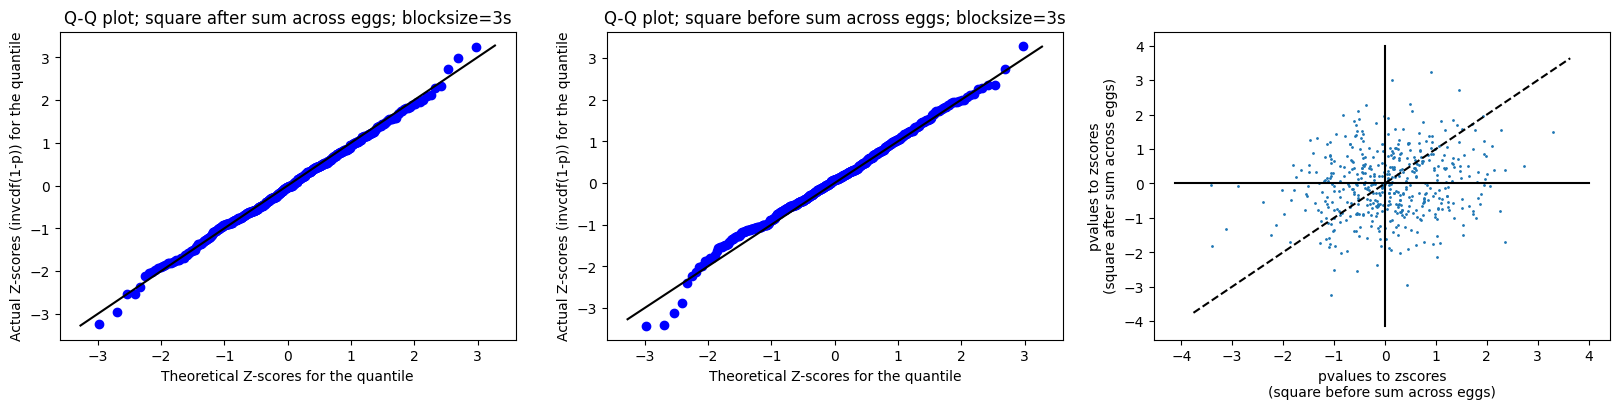

Blocksize: 6 seconds
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -0.5253019400958971
Meta-analysis Z-score if squaring *before* summing 1.7537219674187072
Argmax event for square after summing: ('231', 'New Year Mean 2006-2007', datetime.datetime(2006, 12, 31, 9, 30), datetime.datetime(2007, 1, 1, 12, 29, 59), 97200.0) 3.634468532308831
Argmax event for square before summing: ('83', 'Sea to Shining See', datetime.datetime(2001, 9, 22, 1, 0), datetime.datetime(2001, 9, 22, 2, 59, 59), 7200.0) 3.0353365620606962
Correlation between the two scores: PearsonRResult(statistic=0.17332161788561504, pvalue=0.00014688732508860193)


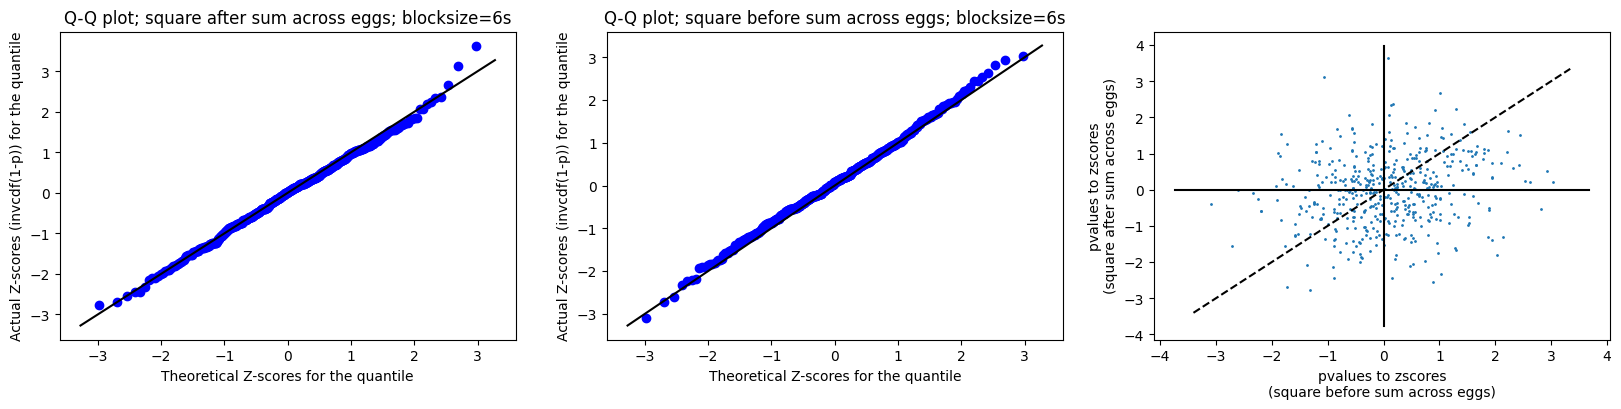

Blocksize: 8 seconds
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -0.5477236890117316
Meta-analysis Z-score if squaring *before* summing 1.2508104658361074
Argmax event for square after summing: ('479', 'Landslide Afghanistan', datetime.datetime(2014, 5, 2, 7, 0), datetime.datetime(2014, 5, 3, 6, 59, 59), 86400.0) 3.0284926499721405
Argmax event for square before summing: ('446', 'Hugo Chavez Dies', datetime.datetime(2013, 3, 5, 20, 25), datetime.datetime(2013, 3, 6, 4, 24, 59), 28800.0) 2.7915655319406683
Correlation between the two scores: PearsonRResult(statistic=0.08554806580936038, pvalue=0.062464960879306114)


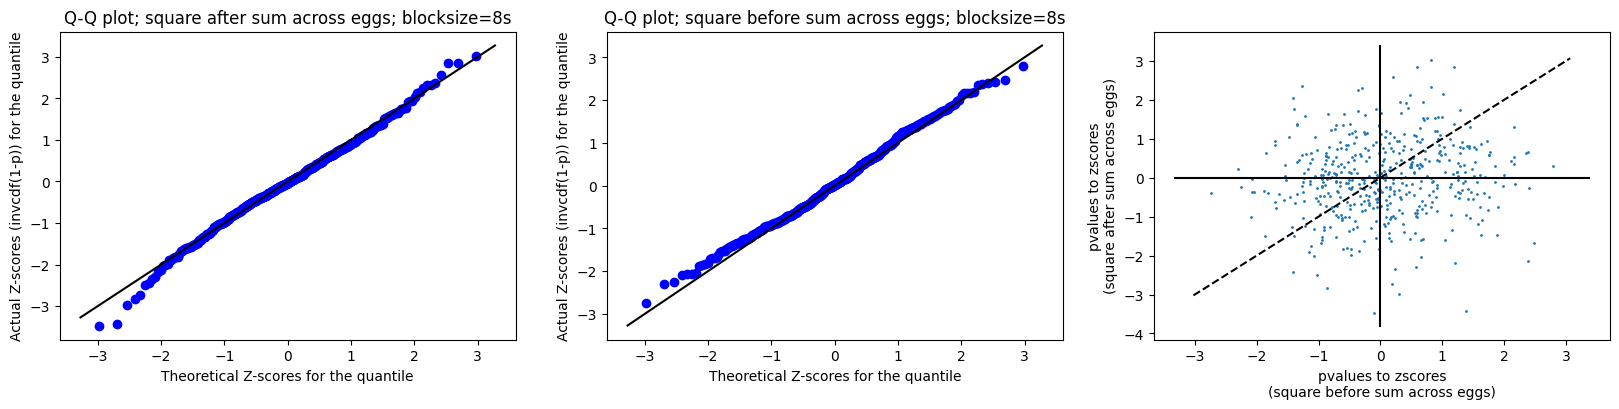

Blocksize: 10 seconds
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -0.0515457318938324
Meta-analysis Z-score if squaring *before* summing 1.033334493745599
Argmax event for square after summing: ('479', 'Landslide Afghanistan', datetime.datetime(2014, 5, 2, 7, 0), datetime.datetime(2014, 5, 3, 6, 59, 59), 86400.0) 3.3825008675982087
Argmax event for square before summing: ('325', 'Moscow Train Bombing', datetime.datetime(2010, 3, 29, 3, 30), datetime.datetime(2010, 3, 29, 7, 29, 59), 14400.0) 2.877882945662356
Correlation between the two scores: PearsonRResult(statistic=0.20273744656339296, pvalue=8.458122875864536e-06)


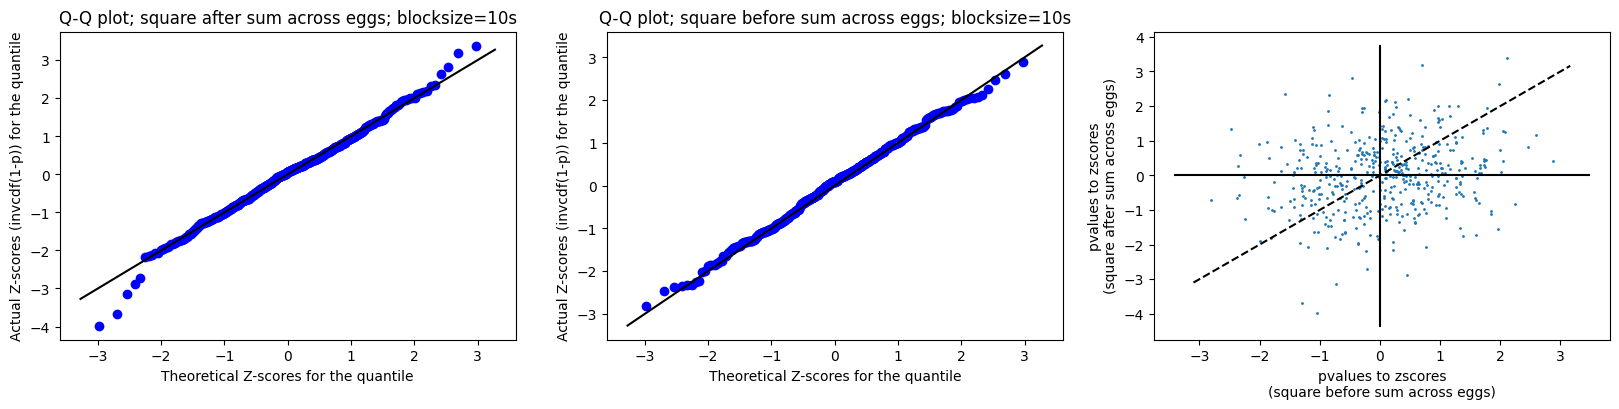

Blocksize: 15 seconds
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 0.36798769641510437
Meta-analysis Z-score if squaring *before* summing 2.04233350885786
Argmax event for square after summing: ('172', 'Rantisi Assassination', datetime.datetime(2004, 4, 17, 17, 0), datetime.datetime(2004, 4, 17, 20, 59, 59), 14400.0) 3.2756056678266536
Argmax event for square before summing: ('168', 'Terror Attacks in Madrid', datetime.datetime(2004, 3, 11, 6, 0), datetime.datetime(2004, 3, 11, 10, 59, 59), 18000.0) 2.8704687406591782
Correlation between the two scores: PearsonRResult(statistic=0.19339813442667278, pvalue=2.195285345924157e-05)


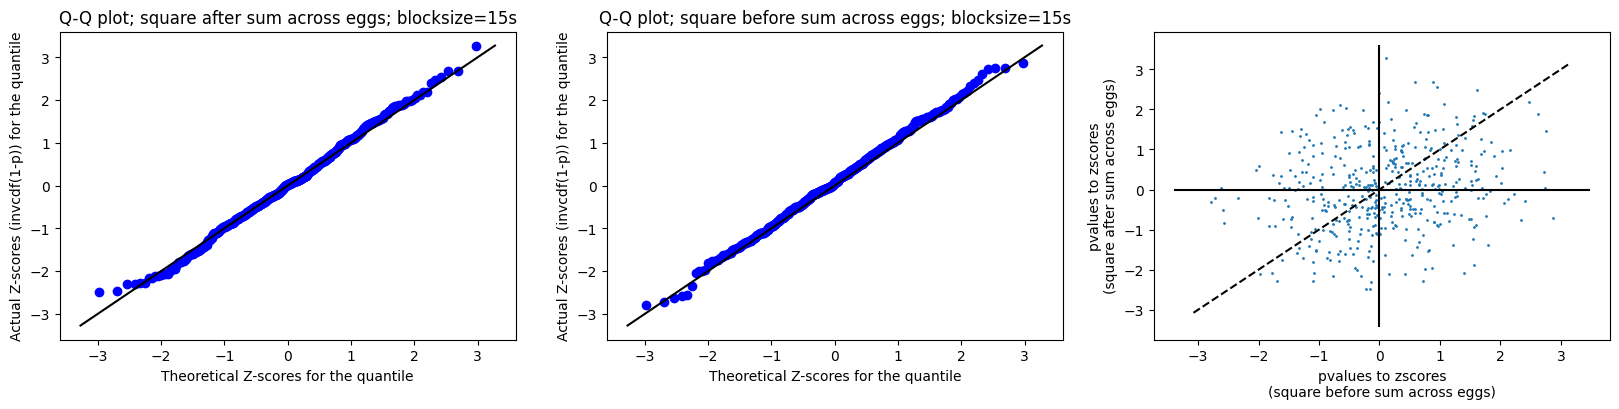

In [23]:
from matplotlib import pyplot as plt

print("num events:", len(included_events))

for (touse_pvaltozs_sumthensquare, touse_pvaltozs_squarethensum, testtype) in [ (all_pvaltozs_sumthensquare, all_pvaltozs_squarethensum, "actual"),
                                                                                 (control_all_pvaltozs_sumthensquare, control_all_pvaltozs_squarethensum, "control")]:
  print("\n\n\n************TEST TYPE:", testtype)
  for blocksize_counter, blocksize in enumerate(BLOCKSIZES):
    print("Blocksize:", blocksize, "seconds")

    for i in range(len(all_pvaltozs_sumthensquare)):
      if np.isnan(all_pvaltozs_sumthensquare[i][blocksize_counter]):
        print("Nan warning for event:", surviving_events[i])

    pvaltoz_sumthensquare = [x for x in np.array([x[blocksize_counter] for x in touse_pvaltozs_sumthensquare]) if np.isnan(x)==False]
    pvaltoz_squarethensum = [x for x in np.array([x[blocksize_counter] for x in touse_pvaltozs_squarethensum]) if np.isnan(x)==False]

    print("Meta-analysis Z-score if squaring *after* summing:", np.sum(pvaltoz_sumthensquare)/np.sqrt(len(pvaltoz_sumthensquare)))
    print("Meta-analysis Z-score if squaring *before* summing", np.sum(pvaltoz_squarethensum)/np.sqrt(len(pvaltoz_squarethensum)))
    print("Argmax event for square after summing:", surviving_events[np.argmax(pvaltoz_sumthensquare)], np.max(pvaltoz_sumthensquare))
    print("Argmax event for square before summing:", surviving_events[np.argmax(pvaltoz_squarethensum)], np.max(pvaltoz_squarethensum))
    print("Correlation between the two scores:", scipy.stats.pearsonr(pvaltoz_squarethensum, pvaltoz_sumthensquare))

    fig, ax = plt.subplots(ncols=3, figsize=(20,4))
    plt.sca(ax[0])
    scipy.stats.probplot(pvaltoz_sumthensquare, dist=scipy.stats.norm, plot=plt, fit=False)
    plt.plot(plt.xlim(), plt.xlim(), color="black")
    plt.title("Q-Q plot; square after sum across eggs; blocksize="+str(blocksize)+"s")
    plt.xlabel("Theoretical Z-scores for the quantile")
    plt.ylabel("Actual Z-scores (invcdf(1-p)) for the quantile")
    plt.sca(ax[1])
    scipy.stats.probplot(pvaltoz_squarethensum, dist=scipy.stats.norm, plot=plt, fit=False)
    plt.plot(plt.xlim(), plt.xlim(), color="black")
    plt.title("Q-Q plot; square before sum across eggs; blocksize="+str(blocksize)+"s")
    plt.xlabel("Theoretical Z-scores for the quantile")
    plt.ylabel("Actual Z-scores (invcdf(1-p)) for the quantile")
    plt.sca(ax[2])
    plt.scatter(pvaltoz_squarethensum, pvaltoz_sumthensquare, s=1)
    plt.plot(plt.xlim(), plt.xlim(), color="black", linestyle="--")
    plt.plot(plt.xlim(), [0,0], color="black")
    plt.plot([0,0], plt.ylim(), color="black")
    plt.xlabel("pvalues to zscores\n(square before sum across eggs)")
    plt.ylabel("pvalues to zscores\n(square after sum across eggs)")
    plt.show()